# Проект «Викишоп» с BERT
Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 
Необходимо обучит модель классифицировать комментарии на позитивные и негативные. В распоряжении есть набор данных с разметкой о токсичности правок.    
Метрика качества F1 должна быть не меньше 0.75.

## 1. Изучение общей информации о датасете

In [6]:
!pip install nltk -q

In [7]:
!pip show notebook jupyterlab_widgets -q

In [8]:
!pip install --upgrade scikit-learn -q

In [9]:
!pip install lightgbm -q

In [10]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/gulnaravolodina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/gulnaravolodina/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gulnaravolodina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import torch
import transformers as ppb
import re

from lightgbm import LGBMClassifier
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import (
      cross_val_score,
      train_test_split,
      RandomizedSearchCV
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_class_weight
from tqdm import notebook
from transformers import DistilBertTokenizer, DistilBertModel
from tqdm.notebook import tqdm
tqdm.pandas()

In [12]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
stop_words = set(stopwords.words('english'))

In [14]:
# функция для загрузки данных из локального файла или URL.
def load_data(local_path, url):
    try:
        if os.path.exists(local_path, index_col=0):
            data = pd.read_csv(local_path)
            print('Данные успешно загружены из локального файла.')
            return data
        else:
            print('Локальный файл не найден, загрузка с URL...')
            raise FileNotFoundError
    except Exception as e:
        print('Ошибка при загрузке данных из локального файла:', e)
    
    # Попытка загрузки из URL
    try:
        data = pd.read_csv(url, index_col=0)
        print('Данные успешно загружены из URL.')
        return data
    except Exception as e:
        print('Ошибка при загрузке данных из URL:', e)
        return None

In [17]:
df = load_data('/Users/gulnaravolodina/Downloads/toxic_comments.csv', 
                 'https://code.s3.yandex.net/datasets/toxic_comments.csv')

Ошибка при загрузке данных из локального файла: exists() got an unexpected keyword argument 'index_col'
Данные успешно загружены из URL.


In [18]:
data = df.copy()

In [19]:
data.isnull().sum()

text     0
toxic    0
dtype: int64

In [20]:
data.sample(3)

,text,toxic
56239,"""\n\nThe following quotes are taken verbatim f...",0
144762,"""\n\nQuicksilver, you can speculate about indí...",0
47850,Elderly Persian\n\nI have contributed a photo ...,0


### Вывод по блоку
Получен датасет с данными, пропущенных значений нет, данных достаточно для анализа

### 2. Обработка данных

In [23]:
# посмотрим распределение токсичных комментариев
data.toxic.value_counts(normalize=True)

toxic
0    0.898388
1    0.101612
Name: proportion, dtype: float64

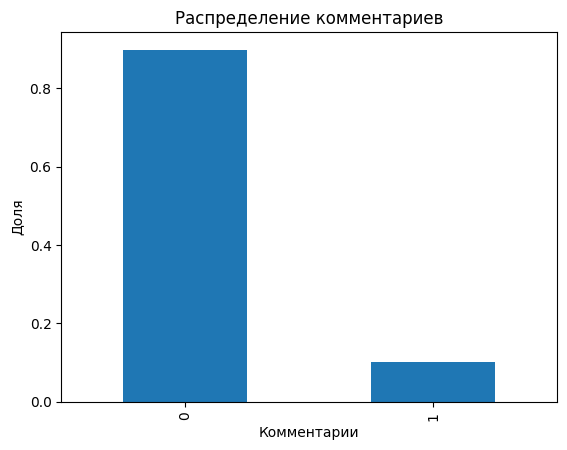

In [24]:
data.toxic.value_counts(normalize=True).plot(kind='bar') 
plt.xlabel('Комментарии')
plt.ylabel('Доля')
plt.title('Распределение комментариев')
plt.show()

In [27]:
# функция для преобразования частей речи
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1]  
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [28]:
lemmatizer = WordNetLemmatizer()

In [29]:
# функция для лемматизации текста
def lemmatize(text):
    words = word_tokenize(text) 
    lemm_list = []
    
    # Используем map для применения функции ко всем словам
    lemm_list = list(map(lambda word: lemmatizer.lemmatize(word, pos=get_wordnet_pos(word)), words))
    
    return " ".join(lemm_list)

In [32]:
# функция для очистки текста от лишних символов и стоп-слов
def clear_text(text):
    text_clear = re.sub(r'[^a-zA-Z\s]', ' ', text).lower() 
    text_clear = re.sub(r'\s+', ' ', text_clear)
    words = text_clear.split()
    words_without_stopwords = [word for word in words if word not in stop_words]
    return ' '.join(words_without_stopwords)

In [33]:
# добавим к исходному датасету новый столбец с очищенным текстом
data['cleaned_text'] = data['text'].progress_apply(clear_text) 

  0%|          | 0/159292 [00:00<?, ?it/s]

In [34]:
# добавим к исходному датасету новый столбец с лемматизированным текстом
data['lemmatized_text'] = data['cleaned_text'].progress_apply(lemmatize)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [35]:
data.sample(5)

,text,toxic,cleaned_text,lemmatized_text
32707,name \n\nLaura Gray Vinning Webber Spencer,0,name laura gray vinning webber spencer,name laura gray vinning webber spencer
48456,"""\n If the reader hasn't progressed far enough...",0,reader progressed far enough learning english ...,reader progress far enough learn english know ...
32830,June 2012 (UTC)\nHave you made sure you have e...,0,june utc made sure explained everything infobo...,june utc make sure explain everything infobox ...
144326,WHAT A LOAD OF CRAP YOU WRITE.,1,load crap write,load crap write
153251,""", 24 July 2009 (UTC)\n\nI just asked that on ...",0,july utc asked talk page waiting response flash,july utc ask talk page wait response flash


In [38]:
data_loaded = data.dropna()

### Вывод
Целевой признак не сбалансирован, что следует учесть при обучении модели.
Данные были лемматизированы при помощи WordNetLemmatizer() в зависимости от части речи, а также очищены от стоп-слов и лишних символов.
Удалены пустые строки.

## 3. Обучение модели

In [41]:
X = data_loaded['lemmatized_text']
y = data_loaded['toxic']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(
 X, y, test_size=0.3, random_state=42, stratify=y
)

X_train.shape, y_train.shape

((111504,), (111504,))

In [44]:
RANDOM_STATE=42

In [63]:
best_models = {}
def train_single_model(model, params, model_name, results_df, best_models):

    pipeline = Pipeline(steps=[('tfidf', TfidfVectorizer()), ('model', model)])

    # Используем RandomizedSearchCV для нахождения лучших гиперпараметров
    rz_search = RandomizedSearchCV(
        pipeline, 
        params, 
        cv=5,
        scoring='f1',
        n_jobs=-1,
        error_score='raise',
        refit=True
    )

    # Обучаем модель
    rz_search.fit(X_train, y_train)

    mean_fit_time = rz_search.cv_results_['mean_fit_time'][rz_search.best_index_]
    mean_score_time = rz_search.cv_results_['mean_score_time'][rz_search.best_index_]

    # Обновляем DataFrame с результатами
    result = pd.DataFrame([{
        'model_name': model_name,
        'best_params': rz_search.best_params_,
        'f1': rz_search.best_score_,
        'mean_fit_time': mean_fit_time,
        'mean_score_time': mean_score_time
    }])

    results_df = pd.concat([results_df, result], ignore_index=True)

    # Сохраняем лучшую модель в словарь
    best_models[model_name] = rz_search.best_estimator_

    # Выводим результаты
    print('Лучшая модель и её параметры:\n\n', rz_search.best_estimator_)
    print('Метрика лучшей модели на тренировочной выборке:', rz_search.best_score_)

    return results_df, best_models

In [68]:
results_df = pd.DataFrame(columns=['model_name', 'f1', 'mean_fit_time', 'mean_score_time'])

In [70]:
model = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', class_weight='balanced')
params = {
    'model__C': [i * 0.1 for i in range(1, 15)]
}
results_df, best_models = train_single_model(model, params, LogisticRegression, results_df, best_models)

Лучшая модель и её параметры:

 Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('model',
                 LogisticRegression(C=1.4000000000000001,
                                    class_weight='balanced', random_state=42,
                                    solver='liblinear'))])
Метрика лучшей модели на тренировочной выборке: 0.7542527318348009


In [74]:
model_2 = DecisionTreeClassifier(random_state=RANDOM_STATE)
params_2 =  {
        'model__max_depth': range(1, 10),
        'model__min_samples_leaf': range(2, 20),
        'model__min_samples_split': range(2, 10)}

results_df, best_models = train_single_model(model_2, params_2, DecisionTreeClassifier, results_df, best_models)

Лучшая модель и её параметры:

 Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('model',
                 DecisionTreeClassifier(max_depth=9, min_samples_leaf=9,
                                        random_state=42))])
Метрика лучшей модели на тренировочной выборке: 0.6024401384031173


In [77]:
pd.set_option('display.max_columns', None)
display(results_df)

,model_name,f1,mean_fit_time,mean_score_time,best_params
0,<class 'sklearn.linear_model._logistic.Logisti...,0.754253,8.120547,1.470695,{'model__C': 1.4000000000000001}
1,<class 'sklearn.tree._classes.DecisionTreeClas...,0.602440,14.864617,1.445526,"{'model__min_samples_split': 2, 'model__min_sa..."


Для финального тестирования будет использована модель LogisticRegression, показавшая лучшую метрику на тренировочной выборке и меньшее среднее время обучения

In [91]:
display(best_models)

{sklearn.linear_model._logistic.LogisticRegression: Pipeline(steps=[('tfidf', TfidfVectorizer()),
                 ('model',
                  LogisticRegression(C=1.4000000000000001,
                                     class_weight='balanced', random_state=42,
                                     solver='liblinear'))]),
 sklearn.tree._classes.DecisionTreeClassifier: Pipeline(steps=[('tfidf', TfidfVectorizer()),
                 ('model',
                  DecisionTreeClassifier(max_depth=9, min_samples_leaf=9,
                                         random_state=42))])}

In [101]:
model_best = make_pipeline(TfidfVectorizer(), LogisticRegression(
                    C=1.4000000000000001, random_state=RANDOM_STATE, solver='liblinear', class_weight='balanced')) 

# Обучение модели на тренировочных данных
model_best.fit(X_train, y_train)
# Предсказание на тестовой выборке
y_pred_mod = model_best.predict(X_test)

# Вычисление F1-меры на тестовой выборке
f1_test = f1_score(y_test, y_pred_mod)

print(f"F1 на тестовой выборке: {f1_test:.4f}")

F1 на тестовой выборке: 0.7575


### Вывод
Были обучены 2 модели LogisticRegression и DecisionTreeClassifier
Лучший результат показала модель LogisticRegression: 
- Лучшие гиперпараметры(C=1.4000000000000001, class_weight='balanced', random_state=42, solver='liblinear'))])
- Метрика лучшей модели на тренировочной выборке: 0.7542527318348009

Результат модели на тестовой выборке F1: 0.7575

### 4. Модель BERT

In [ ]:
# Возьмем небольшое количество примеров для экономии ресурсов.
df_bert = df.sample(400).reset_index(drop=True)

In [ ]:
# Загрузка предобученной модели/токенизатора
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [ ]:
# изменим максимальную длину токенов
def split_text(text, max_length=512):
    tokens = tokenizer.tokenize(text)
    chunks = []
    for i in range(0, len(tokens), max_length):
        chunks.append(tokens[i:i + max_length])
    return chunks

In [ ]:
tokenized = df_bert['text'].apply(lambda x: split_text(x))

In [ ]:
max_len = 0
for i in tokenized:
    for chunk in i:
        if len(chunk) > max_len:
            max_len = len(chunk)

In [ ]:
padded = np.array([tokenizer.convert_tokens_to_ids(chunk) + [0] * (max_len - len(chunk)) for chunks in tokenized for chunk in chunks])
attention_mask = np.where(padded != 0, 1, 0)

In [ ]:
np.array(padded).shape

In [ ]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

In [ ]:
# создадим входной вектор из матрицы токенов и передадим его в модель
input_ids = torch.tensor(padded)
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

In [ ]:
batch_size = 100
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = input_ids[batch_size * i:batch_size * (i + 1)]
    attention_mask_batch = attention_mask[batch_size * i:batch_size * (i + 1)]

    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)
    
    embeddings.append(batch_embeddings[0][:, 0, :].numpy())

In [ ]:
features = np.concatenate(embeddings)
display(features.shape)
 
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X_bert = features
y_bert = df_bert['toxic']
 
# разделяем модель на обучающую и валидационную выборку
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(
 X_bert, y_bert, test_size=0.5, random_state=42
)
 
# зададим алгоритм для модели
model = LogisticRegression(random_state=42)

model.fit(X_train_bert, y_train_bert)
# Предсказания на тестовой выборке
predictions = model.predict(X_test_bert)
 
# Вычисление F1-меры
f1 = f1_score(y_test_bert, predictions)
print(f"F1 мера: {f1}")


# Кросс-валидация
cross_val_scores = cross_val_score(model, X_bert, y_bert, cv=5)
print(f"Кросс-валидационные оценки: {cross_val_scores}")
print(f"Средняя кросс-валидационная F1 мера: {np.mean(cross_val_scores)}")

Результаты конечно же не релевантны на таком объеме тем более с дисбалансом классов, но хотелось попробовать и эту модель и показать на ревью код. На выборке большегого размера умирало ядро

## Результаты исследования.

Был получен датасет с данными, пропущенных значений нет, данных достаточно для анализа.
По результатам предварительной обработки данных выявлено, что целевой признак не сбалансирован, что было учтено при обучении модели.
Данные были лемматизированы при помощи WordNetLemmatizer() в зависимости от части речи, а также очищены от стоп-слов и лишних символов.
Удалены пустые строки.
Были обучены 2 модели LogisticRegression и DecisionTreeClassifier
Лучший результат показала модель LogisticRegression: 
- Лучшие гиперпараметры: {'model__C': 1.1}
- F1 на валидационных данных: 0.8393532851737187
- Время обучения модели: 119.5159981250763 секунд
- Время предсказания модели: 3.5557587146759033 секунд

Результат модели на тестовой выборке F1: 0.7540